# Импорт библиотек #

In [1]:
import  pandas as pd
from pymystem3 import Mystem
from IPython.core.display import display
import seaborn as sns

## Осмотр данных ##

In [2]:
data = pd.read_csv(filepath_or_buffer='datasets/data.csv')
data.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


<AxesSubplot:>

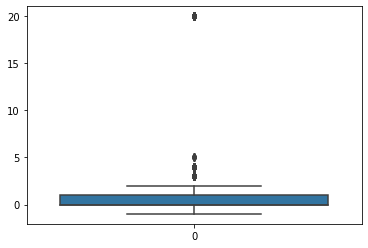

In [4]:
sns.boxplot(data=data['children'])

<AxesSubplot:>

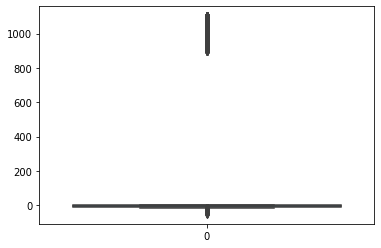

In [5]:
sns.boxplot(data=data['days_employed'] / 365)

<AxesSubplot:>

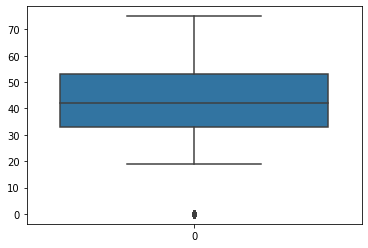

In [6]:
sns.boxplot(data=data['dob_years'])

<AxesSubplot:>

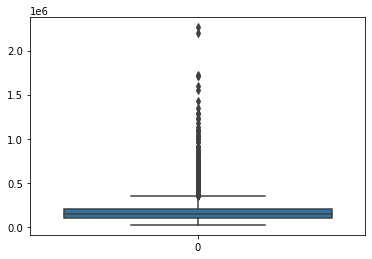

In [7]:
sns.boxplot(data=data['total_income'])

**Вывод**
1. data['days_employed']:
    - отрицательные значения/дробные значения - как интерпретировать?
2. data['education']:
    - изменить тип на 'category'
3. data['education_id']:
    - удалить
4. data['family_status']:
    - изменить тип на 'category'
5. data['family_status_id']:
    - удалить
6. data['gender']:
    - изменить тип на 'category'
7. data['income_type']:
    - изменить тип на 'category'
8. data['total_income']:
    - предложить варианты сегментации заемщиков
9. data['purpose']:
    - выделить основные сегменты
10. обнаружены аномальные данные data['children'] = 20
11. обнаружены аномальные данные data['days_employed'] - стаж более 800 лет
12. обнаружены аномальные данные data['dob_years'] - 0, 80

## Предобработка данных ##

### Обработка пропусков

In [8]:
data[data['dob_years'] < 18]['dob_years'].unique()

array([0], dtype=int64)

In [9]:
data[data['dob_years'] < 18] = 18

In [10]:
print(data.isna().sum())
data = data.fillna(0)
print(data.isna().sum())

children               0
days_employed       2164
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2164
purpose                0
dtype: int64
children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64


#### Замена значений data['children'] ####

In [11]:
print(data['children'].unique())
data[data['children'] == -1] = 0
print(data['children'].unique())

[ 1  0  3  2 18 -1  4 20  5]
[ 1  0  3  2 18  4 20  5]


**Вывод**
1. произведена замена пропущенных значений на 0 для:
    - data['days_employed'] - косвенные данные указывающие на стаж заемщика отсутствуют
      Возможные причины возникновния:
      * заемщик не указал свой стаж
      * человевеский фактор
      * потеря данных при формировании dataset
      * пропуски составляют ~10% dataset, поэтому не удаляю
    - data['total_income'] - косвенные данные указывающие на заработок заемщика отсутствуют
      Возможные причины возникновния:
      * заемщик не указал свой стаж
      * человевеский фактор
      * потеря данных при формировании dataset
      * пропуски составляют ~10% dataset, поэтому не удаляю
2. пропущенные значения удалены
3. произведена замена значения "-1" data['children'] на 0, т.к.
    - отрицательное количество детей невозможно
    - косвенные данные указывающие на количество детей отсутствуют
4. в dataset присутствует заёмщик с 20 детьми
    - данные позволяющие подтвердить указанное количество отсутствуют
    Возможные причины возникновения:
    - опечатка
    - действительно 20 детей
    Оставляю без изменений.

### Изменение типов данных ###

#### Перевод значений строковых переменных в нижний регистр ####

In [12]:
def lower_data():
    for column in data.columns:
        if data.dtypes[column] == 'object':
            data[column] = data[column].str.strip()
            data[column] = data[column].str.lower()

lower_data()

In [13]:
data

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,f,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,f,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,среднее,1,женат / замужем,0,m,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,m,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,f,пенсионер,0,158616.077870,сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1,-4529.316663,43,среднее,1,гражданский брак,1,f,компаньон,0,224791.862382,операции с жильем
21521,0,343937.404131,67,среднее,1,женат / замужем,0,f,пенсионер,0,155999.806512,сделка с автомобилем
21522,1,-2113.346888,38,среднее,1,гражданский брак,1,m,сотрудник,1,89672.561153,недвижимость
21523,3,-3112.481705,38,среднее,1,женат / замужем,0,m,сотрудник,1,244093.050500,на покупку своего автомобиля


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     21525 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21377 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21377 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21377 non-null  object 
 8   income_type       21377 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      21525 non-null  float64
 11  purpose           21377 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [15]:
data['days_employed'] = data['days_employed'].astype('int')
data['gender'] = data['gender'].astype('category')
data['income_type'] = data['income_type'].astype('category')
data['education'] = data['education'].astype('category')
data['family_status'] = data['family_status'].astype('category')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   children          21525 non-null  int64   
 1   days_employed     21525 non-null  int32   
 2   dob_years         21525 non-null  int64   
 3   education         21377 non-null  category
 4   education_id      21525 non-null  int64   
 5   family_status     21377 non-null  category
 6   family_status_id  21525 non-null  int64   
 7   gender            21377 non-null  category
 8   income_type       21377 non-null  category
 9   debt              21525 non-null  int64   
 10  total_income      21525 non-null  float64 
 11  purpose           21377 non-null  object  
dtypes: category(4), float64(1), int32(1), int64(5), object(1)
memory usage: 1.3+ MB


**Вывод**

1. строковые значения переведены в нижний регистр
2. тип данных data['days_employed'] изменен на 'int'
3. тип данных изменен на 'category' для следующих столбцов:
    - data['gender']
    - data['income_type']
    - data['education']
    - data['family_status']


### Обработка дубликатов ###

In [16]:
data.duplicated().sum()

217

#### Удаление cтолбцов data['education_id'], data['family_status_id'] ####

In [18]:
data = data.drop(columns=['family_status_id', 'education_id'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   children       21525 non-null  int64   
 1   days_employed  21525 non-null  int32   
 2   dob_years      21525 non-null  int64   
 3   education      21377 non-null  category
 4   family_status  21377 non-null  category
 5   gender         21377 non-null  category
 6   income_type    21377 non-null  category
 7   debt           21525 non-null  int64   
 8   total_income   21525 non-null  float64 
 9   purpose        21377 non-null  object  
dtypes: category(4), float64(1), int32(1), int64(3), object(1)
memory usage: 1010.0+ KB


**Вывод**
1. дубликаты удалены
2. удалены столбцы
    - data['family_status_id']
    - data['education_id']
   т.к. дублируют данные содержащиеся в data['education'] и data['family_status']

### Лемматизация ###

#### Лемматизация data['purpose'] ####

In [19]:
data.isna().sum()
data = data.dropna().reset_index(drop=True)

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21377 entries, 0 to 21376
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   children       21377 non-null  int64   
 1   days_employed  21377 non-null  int32   
 2   dob_years      21377 non-null  int64   
 3   education      21377 non-null  category
 4   family_status  21377 non-null  category
 5   gender         21377 non-null  category
 6   income_type    21377 non-null  category
 7   debt           21377 non-null  int64   
 8   total_income   21377 non-null  float64 
 9   purpose        21377 non-null  object  
dtypes: category(4), float64(1), int32(1), int64(3), object(1)
memory usage: 1003.1+ KB


In [21]:
m = Mystem()
for purpose in data['purpose'].unique():
    lemma = ' '.join(m.lemmatize(purpose))
    for _ in range(len(data)):
        if purpose in data.loc[_, 'purpose']:
            data.loc[_, 'purpose'] = lemma

#### Категоризация data['purpose'] ####

In [22]:
for lem_purpose in ['недвижимость', 'жилье', 'автомобиль', 'свадьба', 'образование']:
    for _ in range(len(data)):
        if lem_purpose in data.loc[_, 'purpose']:
            data.loc[_, 'purpose'] = lem_purpose

In [23]:
data['purpose'] = data['purpose'].replace(to_replace='образование  \n',
                                          value='образование').\
                                  replace(to_replace='жилье',
                                          value='недвижимость')

In [24]:
data['purpose'] = data['purpose'].astype('category')

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21377 entries, 0 to 21376
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   children       21377 non-null  int64   
 1   days_employed  21377 non-null  int32   
 2   dob_years      21377 non-null  int64   
 3   education      21377 non-null  category
 4   family_status  21377 non-null  category
 5   gender         21377 non-null  category
 6   income_type    21377 non-null  category
 7   debt           21377 non-null  int64   
 8   total_income   21377 non-null  float64 
 9   purpose        21377 non-null  category
dtypes: category(5), float64(1), int32(1), int64(3)
memory usage: 857.1 KB


In [26]:
data.duplicated().sum()

404

**Вывод**
1. проведена лемматизация data['purpose']
2. тип данных data['purpose'] изменен на 'category'
3. список целей займа ограничен 4-я позициями

### Категоризация данных ###

#### Категоризация заёмщиков по количеству детей ####

In [27]:
print(data['children'].describe())
print(data['children'].unique())

count    21377.000000
mean         0.541657
std          1.376992
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         20.000000
Name: children, dtype: float64
[ 1  0  3  2  4 20  5]


In [28]:
for _ in range(len(data)):
    if data.loc[_, 'children'] == 0: data.loc[_, 'cat_children'] = 'бездетный'
    elif 1 <= data.loc[_, 'children'] <= 3: data.loc[_, 'cat_children'] = 'не более 3 детей'
    else: data.loc[_, 'cat_children'] = 'многодетный'


data['cat_children'] = data['cat_children'].astype('category')

#### Категоризация заемщиокв по уровню дохода ####

In [29]:
print(data['total_income'].describe())

count    2.137700e+04
mean     1.505642e+05
std      1.100633e+05
min      0.000000e+00
25%      8.860795e+04
50%      1.355090e+05
75%      1.955499e+05
max      2.265604e+06
Name: total_income, dtype: float64


In [30]:
for _ in range(len(data)):
    if data.loc[_, 'total_income'] <= 89062: data.loc[_, 'cat_total_income'] = 'низкий'
    elif 89062 < data.loc[_, 'total_income'] <= 135760: data.loc[_, 'cat_total_income'] = 'средний'
    elif 135760 < data.loc[_, 'total_income'] <= 195855: data.loc[_, 'cat_total_income'] = 'выше среднего'
    else: data.loc[_, 'cat_total_income'] = 'высокий'

**Вывод**
1. выполнена категоризация заемщиков по количеству детей.
   Критерии:
   - 0 детей - бездетный
   - от 1 до 3(включительно) - не более 3 детей
   - больше 3 детей - многодетный
2. дополнительная категоризация заемщиков по семейному положению не проводилась. будут использованы категории представленные в dataset-е
3. проведена категоризация заёмщиков по уровню дохода.
   Критерии:
   - до 89062 - низкий
   - от 89062 до 135760 - средний
   - от 135760 до 195855 - выше среднего
   - выше 195855 - высокий

##  Зависимость м/у наличием детей и возвратом кредита в срок ##

In [31]:
child_pivot = data.pivot_table(values='debt', index='cat_children', aggfunc=['count', 'sum'])
child_pivot['% debt'] = child_pivot['sum'] / child_pivot['count'] * 100
display(child_pivot)

,count,sum,% debt
,debt,debt,
cat_children,,,
бездетный,14080,1058,7.514205
многодетный,125,12,9.600000
не более 3 детей,7172,662,9.230340


**Вывод**
- вероятность просроченных платежей по кредиту у бездетных заемщиков ниже чем у многодетных и заемщиков количество детей у которых не болле 3, на ~2%

## Зависимость между семейным положением и возвратом кредита в срок ##

In [32]:
family_pivot = data.pivot_table(values='debt', index='family_status', aggfunc=['count', 'sum'])
family_pivot['% debt'] = family_pivot['sum'] / family_pivot['count'] * 100
display(family_pivot)

,count,sum,% debt
,debt,debt,
family_status,,,
в разводе,1181,85,7.197290
вдовец / вдова,951,62,6.519453
гражданский брак,4151,386,9.298964
женат / замужем,12302,926,7.527231
не женат / не замужем,2792,273,9.777937


**Вывод**
- вероятность просроченных платежей по кредиту у заемщиков не состоящих в браке и состощих в гражданском браке выше в сравнении с:
    1. овдовевшими заемщиками на  ~3%
    2. заемщиками в разводе на ~3%
    3. заемщиками в браке на ~3%

## Зависимость между уровнем дохода и возвратом кредита в срок ##

In [33]:
income_pivot = data.pivot_table(values='debt', index='cat_total_income', aggfunc=['count', 'sum'])
income_pivot['% debt'] = income_pivot['sum'] / income_pivot['count'] * 100
display(income_pivot)

,count,sum,% debt
,debt,debt,
cat_total_income,,,
высокий,5324,382,7.175056
выше среднего,5331,478,8.966423
низкий,5396,419,7.765011
средний,5326,453,8.505445


**Вывод**
- вероятность просроченных платежей по кредиту у заемщиков со средним доходом и выше среднего выше в сравнении с:
    1. заемщиками с высоким доходом на ~2%
    2. заемщиками с низким доходом на ~2%

## Зависимость цели кредита и возвратом в срок ##

In [34]:
purpose_pivot = data.pivot_table(values='debt', index='purpose', aggfunc=['count', 'sum'])
purpose_pivot['% debt'] = purpose_pivot['sum'] / purpose_pivot['count'] * 100
display(purpose_pivot)

,count,sum,% debt
,debt,debt,
purpose,,,
автомобиль,4282,399,9.318076
недвижимость,10769,779,7.233726
образование,3994,370,9.263896
свадьба,2332,184,7.890223


**Вывод**
- самая низкия вероятность просроченных платежей по кредиту полученному для приобретения недвижимости
- высокая вероятность просроченных платежей для кредитов полученных на образование и приобретение автомобиля

## Вывод ##
В ходе обработки данных выявлены следующие аномалии:
    - возраст заемщика < 18
    - стаж > 57 лет
    - возраст заёмщика > 65 лет
    - количество детей у заемщика > 20
Если удалить заемщиков удовлетворяющих приведенным условиям результаты исследования могут измениться.

В ходе исследования выявлены зависимости возникновения задолженности по кредиту от:
    * целей кредита
    * уровня дохода заемщика
    * наличием детей у заемщика
    * семейного положения заемщика

1. Вероятность просроченных платежей по кредиту выше у заемщиков с детьми.
2. Вероятность просроченных платежей по кредиту выше у заемщиков не состоящих в браке или состоящих в гражданском браке.
3. Вероятность просроченных платежей по кредиту выше у заемщиков с уровнем дохода от 89062 до 195855.
4. Вероятность просроченных платежей по кредиту выше у по кредитам целью которых является образование или приобретение автомобиля.